In [1]:
from pathlib import Path
import time
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt

exec(open("../functions.py").read())

In [2]:
# set basic parameters and subdirectory
part_n = 500
e_part_r = 0.8
e_mean = 0
ei_std_s = [4, 4]
waiting_time = 300
interval_len = waiting_time + 3200
freq = 0
subdirectory = ("{:n}_".format(part_n)
                + "{:n}_".format(e_part_r)
                + "{:n}_".format(e_mean)
                + "{0:n}-{1:n}/".format(ei_std_s[0],
                                        ei_std_s[1]))
#Path(subdirectory).mkdir()
print(ei_spectral_radius_fct(e_part_r, ei_std_s))

seed = 1705010765#round(time.time())
subdirectory = (subdirectory + "{:n}_".format(seed)
                + "{0:n}-{1:n}_".format(interval_len, 
                                        waiting_time)
                + "{:n}/".format(freq))
#Path(subdirectory).mkdir()
print(subdirectory)

4.0
500_0.8_0_4-4/1705010765_3500-300_0/


In [3]:
# generate and save parameters for simulation
key = jax.random.PRNGKey(seed)

sub_part_r_s = jnp.array([e_part_r, 1 - e_part_r])
sub_part_n_s = sub_part_n_s_fct(part_n, sub_part_r_s)
unscaled_mean = ei_mean_balancer(sub_part_r_s, e_mean)
unscaled_std = jnp.tile(jnp.array([ei_std_s]), (2, 1))
connectivity_n = 5
in_r = 1.
rewiring_prob = 1.
[connectivity_s, key] = row_sum_removing_sparsifier(
  connectivity_s_generator(sub_part_n_s, unscaled_mean, unscaled_std, jnp.array([[0]]),
                           connectivity_n,
                           key),
  sub_part_n_s, in_r, rewiring_prob)

sub_part_n_s_ext_gen = jnp.array([part_n])
ext_part_n = 1
ext_sub_part_r_s = jnp.array([1.])
ext_sub_part_n_s = sub_part_n_s_fct(ext_part_n, ext_sub_part_r_s)
unscaled_ext_mean = jnp.array([[0.]])
unscaled_ext_std = jnp.array([[1.]])
ext_connectivity_n = 10
angle_s = jnp.arange(ext_connectivity_n) / (ext_connectivity_n - 1) * jnp.pi / 2
inter_instance_correlation = jnp.cos(jnp.expand_dims(angle_s, 0) - jnp.expand_dims(angle_s, 1))
[ext_connectivity_s, key] = ext_connectivity_s_generator(
  sub_part_n_s_ext_gen, ext_sub_part_n_s,
  unscaled_ext_mean, unscaled_ext_std, inter_instance_correlation,
  ext_connectivity_n, 
  key)

phase_n = 1
[phase_s, key] = phase_s_generator(ext_part_n, phase_n, key)
phase_s = 0 * phase_s # since freq = 0

amp_s = jnp.expand_dims(jnp.array([0.6, 1.2, 1.8, 2.4]),
                        # or (wave_n, ext_part_n) array so different ext parts have different amps
                        1)
freq_s = jnp.full(amp_s.shape, freq)
wave_s = jnp.concatenate([amp_s, freq_s], axis = 1)
wave_n = wave_s.shape[0]

init_condition_n = 5
ext_condition_n = ext_connectivity_n * phase_n
init_condition_n_free = init_condition_n * ext_condition_n
[init_condition_s, key] = init_condition_s_generator(part_n, 
                                                           jnp.full((part_n, ), 0), jnp.identity(part_n), 
                                                           init_condition_n_free, key)

label_s = jnp.array([1])
label_s_free = jnp.array([0])
time_interval_s = jnp.array([[0, interval_len]])
labeled_time_interval_s = [time_interval_s, label_s]
labeled_time_interval_s_free = [time_interval_s, label_s_free]

resolution = 24

condition_n_s = jnp.array([connectivity_n, wave_n, ext_connectivity_n, phase_n,
                             init_condition_n])
condition_n_s_free = jnp.array([connectivity_n, 1, 1, 1,
                                  init_condition_n_free])

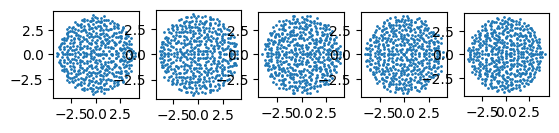

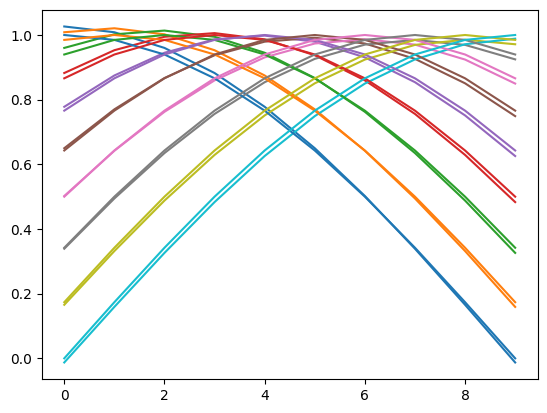

In [4]:
# plot spectra
[fig, subfig_s] = plt.subplots(1, int(connectivity_n), squeeze = False)
for connectivity_idx in range(connectivity_n):
  temp_spectrum = jnp.linalg.eig(connectivity_s[connectivity_idx])[0]
  subfig_s[0, connectivity_idx].plot(jnp.real(temp_spectrum), jnp.imag(temp_spectrum),
                                  linestyle="", marker=".", markersize = 2)
  subfig_s[0, connectivity_idx].set_aspect('equal')

plt.figure()
plt.plot(ext_connectivity_s[:, :, 0] @ ext_connectivity_s[:, :, 0].T / part_n)
plt.plot(inter_instance_correlation);

In [5]:
kernel_power = 2 # jnp.inf
max_kernel_fraction = 0.4 # 0.96
gau_window_len = jnp.floor(3200 * max_kernel_fraction).astype(int)

kernel = kernel_s_fct(jnp.array([gau_window_len]), resolution, kernel_power, max_kernel_fraction)[0]

# initialize and run stats
def short_weighted_mean_cov_s_fct(traj_s):
  skipped_frame_n = waiting_time * resolution
  mean_s = mean_s_fct(traj_s[..., skipped_frame_n:])
  return([mean_s, weighted_cov_s_fct(traj_s[..., skipped_frame_n:], mean_s, kernel)])

start_time = time.time()

stat_s_free = mean_cov_s_initializer(condition_n_s_free, part_n) # for baseline
stat_s_free = stat_s_fct(connectivity_s, wave_s[:1], ext_connectivity_s[:1], phase_s[:1], init_condition_s,
                         labeled_time_interval_s_free, resolution,
                         short_weighted_mean_cov_s_fct, stat_s_free)
np.savez_compressed(subdirectory + "stats_free.npz", *stat_s_free) # jax has not implemented savez_compressed as of 23/08/23

stat_s = mean_cov_s_initializer(condition_n_s, part_n)
stat_s = stat_s_fct(connectivity_s, wave_s, ext_connectivity_s, phase_s, init_condition_s[::ext_condition_n],
                    labeled_time_interval_s, resolution, 
                    short_weighted_mean_cov_s_fct, stat_s)
np.savez_compressed(subdirectory + "stats.npz", *stat_s)

end_time = time.time()
print("took {:.2f} mins".format((end_time - start_time) / 60))

[5, 'connectivity_n']
[1, 'wave_n']
[1, 'ext_connectivity_n']
[1, 'phase_n']
[50, 'init_condition_n']
2 stats
expecting 21.25 mins
[5, 'connectivity_n']
[4, 'wave_n']
[10, 'ext_connectivity_n']
[1, 'phase_n']
[5, 'init_condition_n']
2 stats
expecting 83.33 mins
took 106.79 mins


In [6]:
# load stats
stat_s_free = load_as_list(subdirectory + "stats_free.npz")
stat_s = load_as_list(subdirectory + "stats.npz")

In [7]:
start_time = time.time()

# pc
pc_s_free = es_s_fct(stat_s_free[1])
pc_s = es_s_fct(stat_s[1])

# mean_angle_cos
angle_cos_s = jnp.concatenate(
  [vector_angle_cos_s_fct(stat_s[0][:, :, 0:1], 
                          jnp.roll(stat_s[0], init_condition_idx, axis = 4))
   for init_condition_idx in range(1, jnp.floor(init_condition_n / 2 + 1).astype(int))], axis = 4)
# os
mode_os_s_free = jnp.concatenate(
  [ori_similarity_s_fct(pc_s_free, [jnp.roll(pc_s_free[idx], init_condition_idx, axis = 4)
                                    for idx in range(2)])
   for init_condition_idx in range(1, jnp.floor(init_condition_n_free / 2 + 1).astype(int))], axis = 4) # for baseline
mode_os_s = jnp.concatenate(
  [ori_similarity_s_fct([pc_s[idx][:, :, 0:1] for idx in range(2)], 
                        [jnp.roll(pc_s[idx], init_condition_idx, axis = 4) for idx in range(2)])
   for init_condition_idx in range(1, jnp.floor(init_condition_n / 2 + 1).astype(int))], axis = 4)
np.savez_compressed(subdirectory + "similarities.npz", angle_cos_s, mode_os_s_free, mode_os_s)

end_time = time.time()
print("took {:.2f} mins".format((end_time - start_time) / 60))

took 0.58 mins


In [8]:
[angle_cos_s, mode_os_s_free, mode_os_s] = load_as_list(subdirectory + "similarities.npz")

In [9]:
#export to predictions
np.savez_compressed(subdirectory + "../../../modes.npz", 
                    part_n, 
                    gau_window_len, 
                    angle_cos_s, mode_os_s_free, mode_os_s)

plotting

In [10]:
def mode_val_stat_s_fct(stat_s):
  return([fct(stat_s, axis = (0, 3, 4)) for fct in [jnp.mean, jnp.std]])

mode_os_s_free_stat_s = [jnp.mean(mode_os_s_free), jnp.std(mode_os_s_free)]
val_stat_s = [mode_val_stat_s_fct(angle_cos_s), 
              mode_val_stat_s_fct(mode_os_s)]

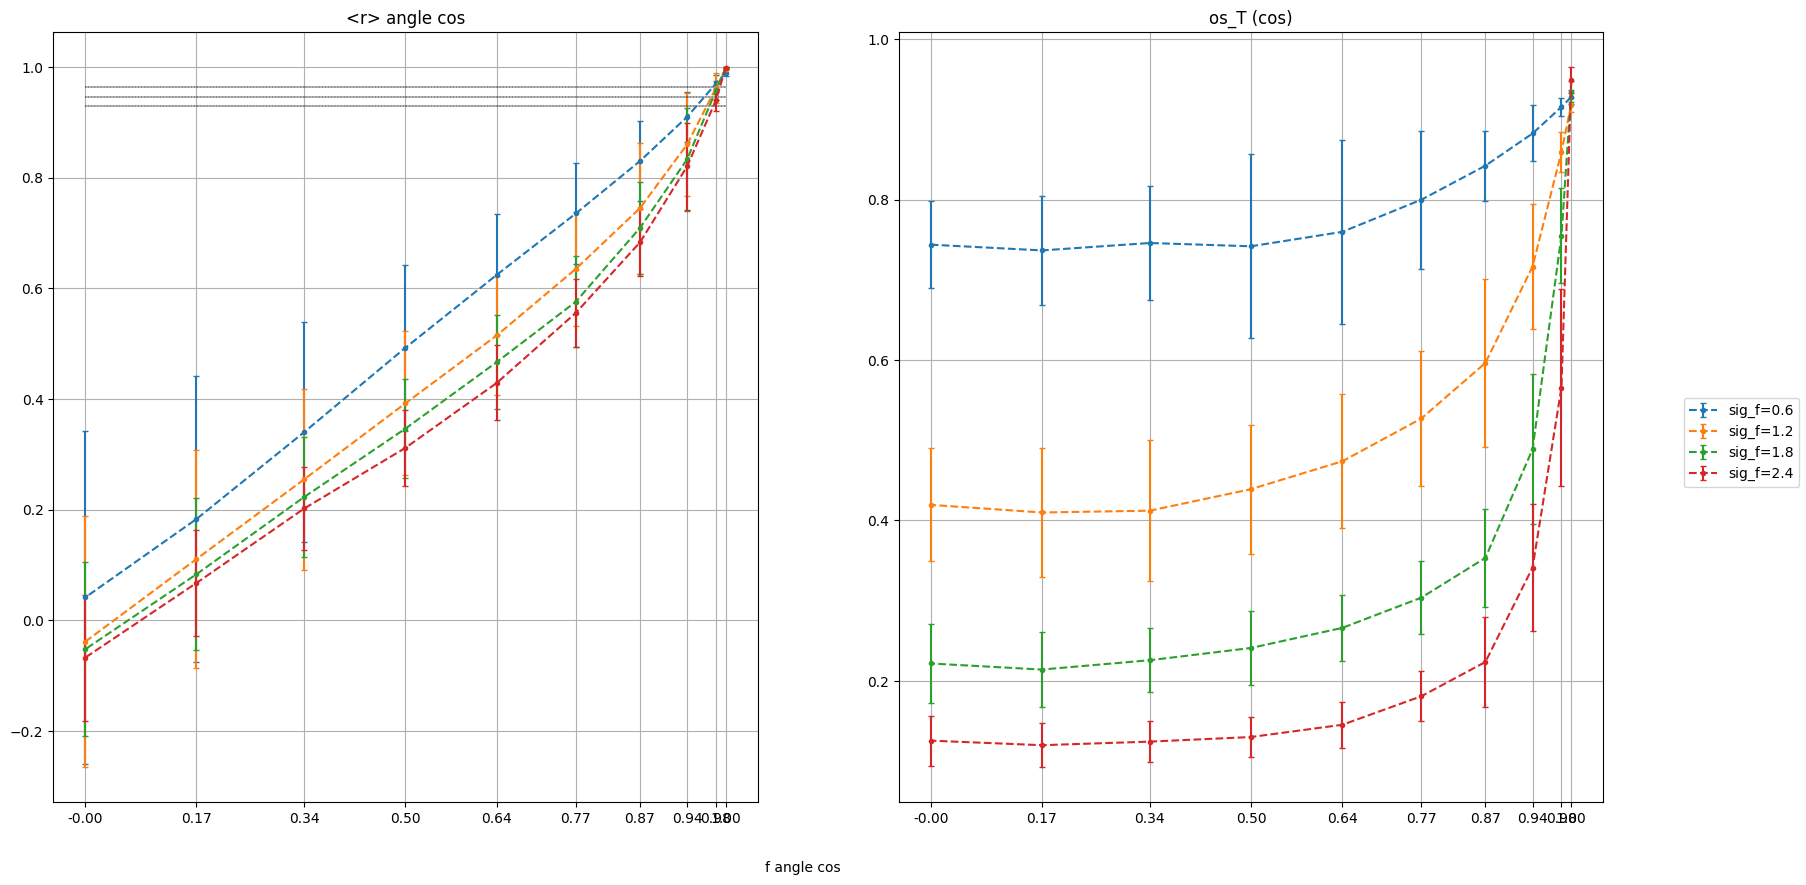

In [11]:
f_angle_cos_s = jnp.cos(angle_s)

[fig, subfig_s] = plt.subplots(1, 2, figsize = (20, 10), squeeze = False)

for ext_idx in range(wave_n):
  for stat_idx in range(2):
    plot_idx = jnp.unravel_index(stat_idx, (1, 2))
    subfig_s[plot_idx].errorbar(f_angle_cos_s, val_stat_s[stat_idx][0][ext_idx],
                                yerr = val_stat_s[stat_idx][1][ext_idx],
                                capsize = 2, label = ("sig_f={0:.1f}".format(amp_s[ext_idx, 0]) 
                                                      if stat_idx == 0 else ""), 
                                linestyle = "--", marker = ".")
  subfig_s[0, 0].hlines(mode_os_s_free_stat_s[0] + jnp.array([-1, 0, 1]) * mode_os_s_free_stat_s[1],
                        jnp.min(f_angle_cos_s), jnp.max(f_angle_cos_s), 
                        linestyle = '--', color = 'k', linewidth = 0.2)

subfig_s[0, 0].set(title = "<r> angle cos")
subfig_s[0, 1].set(title = "os_T (cos)")
for stat_idx in range(4):
  plot_idx = jnp.unravel_index(stat_idx, (1, 2))
  subfig_s[plot_idx].set(xticks = f_angle_cos_s, 
                         xticklabels = ["{:.2f}".format(f_angle_cos) for f_angle_cos in f_angle_cos_s])
  subfig_s[plot_idx].grid()
fig.text(0.5, 0.04, "f angle cos", ha = "center")
fig.legend(loc = "outside right")

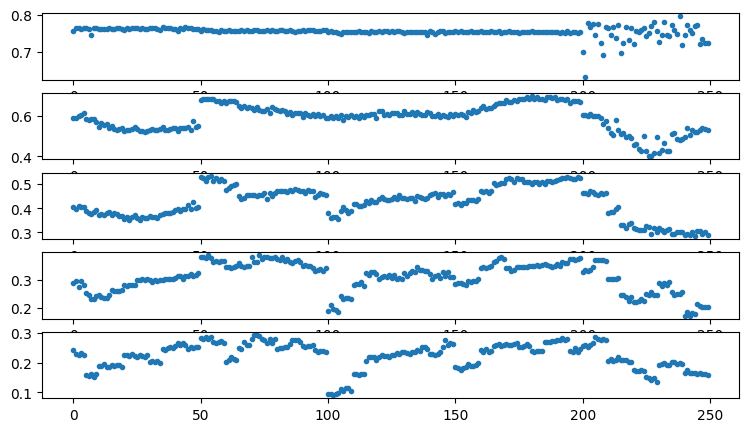

In [12]:
#making sure nothing is strange from the trs
[fig, subfig_s] = plt.subplots(wave_n + 1, 1, figsize = (9, 5), squeeze = False)
subfig_s[0, 0].plot(size_s_fct(pc_s_free[0]).flatten(), label = 0., marker='.', linestyle='')
for wave_idx in range(wave_n):
  subfig_s[wave_idx + 1, 0].plot(
    size_s_fct(pc_s[0][:, wave_idx]).flatten(), label = amp_s[wave_idx, 0],
    marker='.', linestyle='')
# for wave_idx in range(wave_n + 1):
#   subfig_s[wave_idx, 0].set(ylim = (0, 1))